# Importando Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# Importando Dados

In [2]:
past = 'C:/Users/marcio/Documents/Prev_For_ULS/Resultados/tabelas/Previsoes/'

In [3]:
previsoes_np = {}
previsoes = []
for index in range(3):
    with open(past+f'Prev_pro/Previsao_pro{index}.txt', "r") as arquivo:
	    previsoes.append([float(demanda) for demanda in arquivo.read().split(',')])


In [4]:
previsoes_np['demandas'] = previsoes
previsoes_np = pd.DataFrame(previsoes_np)
previsoes_np.head()

,demandas
0,"[9877.404296875, 9904.2919921875, 9926.2109375..."
1,"[9904.1240234375, 9921.4599609375, 9949.382812..."
2,"[9865.751953125, 9890.9169921875, 9911.578125,..."


In [5]:
previsoes_sar = {}
previsoes = []
for index in range(3):
    with open(past+f'Prev_sar/Previsao_sar{index}.txt', "r") as arquivo:
	    previsoes.append([float(demanda) for demanda in arquivo.read().split(',')])
            
previsoes_sar['demandas'] = previsoes
previsoes_sar = pd.DataFrame(previsoes_sar)
previsoes_sar.head()

,demandas
0,"[9817.02138274243, 9909.200053861266, 9936.817..."
1,"[9817.02138274243, 9909.200053861266, 9936.817..."
2,"[9817.02138274243, 9909.200053861266, 9936.817..."


# Funções Auxiliares

In [6]:
def describe_var(dataframe,var):
    resultado_var = {}
    
    for periodo in range(len(dataframe.iloc[0,0])):
        aux = []
        for list in dataframe[var]:
            aux.append(list[periodo])
        resultado_var[f'{var}{periodo+1}'] = aux

    return pd.DataFrame(resultado_var)

In [7]:
def describe_var_grafico(describe1_var,describe2_var,var):
    fig=plt.figure(figsize=(6,3))

    plt.plot(range(len(describe1_var.columns)),describe1_var.iloc[1,:],color='blue',label='Neural Prophet')
    plt.plot(range(len(describe2_var.columns)),describe2_var.iloc[1,:],color='red',label='Sarimax')

    plt.xlabel(var)
    plt.ylabel('Valor Médio')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [8]:
def describe_var_desv_grafico(describe1_var,describe2_var,var):
    fig=plt.figure(figsize=(6,3))

    plt.plot(range(len(describe1_var.columns)),describe1_var.iloc[2,:],color='blue',label='Neural Prophet')
    plt.plot(range(len(describe2_var.columns)),describe2_var.iloc[2,:],color='red',label='Sarimax')

    plt.xlabel(var)
    plt.ylabel('Desvio Padrão')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [9]:
def describe_dist_var(dataframe_1,dataframe_2,var):
    distancias_var = {}
        
    for periodo in range(52):
        aux = []
        for list_1 in dataframe_1[var]:
            for list_2 in dataframe_2[var]:
                aux.append(math.fabs(list_1[periodo]-list_2[periodo]))
        distancias_var[f'x{periodo+1}'] = aux

    return pd.DataFrame(distancias_var)

In [10]:
def plot_dist(describe_dist_var,var):
    fig=plt.figure(figsize=(6,3))

    plt.plot(range(52),describe_dist_var.iloc[1,:])
    plt.xlabel(var)
    plt.ylabel('Distância Média')
    plt.legend()
    plt.tight_layout()
    #plt.savefig(f'Imgs\{var}DistMedia.png', format='png')
    plt.show()

# Analise Dos Resultados Do ULS

In [11]:
vars1 = describe_var(previsoes_np,'demandas')
vars2 = describe_var(previsoes_sar,'demandas')

In [12]:
vars1

,demandas1,demandas2,demandas3,demandas4,demandas5,demandas6,demandas7,demandas8,demandas9,demandas10,...,demandas43,demandas44,demandas45,demandas46,demandas47,demandas48,demandas49,demandas50,demandas51,demandas52
0,9877.404297,9904.291992,9926.210938,9946.969727,9970.284180,9993.278320,10025.777344,10034.484375,10083.915039,10106.410156,...,9824.843750,9817.258789,9814.242188,9828.885742,9822.790039,9838.563477,9842.542969,9866.442383,9881.880859,9896.302734
1,9904.124023,9921.459961,9949.382812,9974.330078,9980.956055,9999.083984,10034.758789,10041.619141,10076.623047,10091.346680,...,9817.453125,9826.770508,9828.689453,9839.131836,9849.214844,9864.067383,9881.081055,9898.016602,9915.875000,9925.100586
2,9865.751953,9890.916992,9911.578125,9931.810547,9981.151367,9980.708008,10018.535156,10019.770508,10053.234375,10078.208984,...,9739.068359,9757.106445,9759.158203,9771.788086,9768.012695,9780.042969,9777.975586,9781.503906,9793.685547,9796.599609


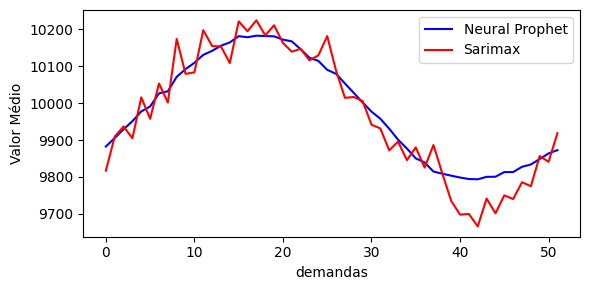

In [13]:
describe_var_grafico(vars1.describe(),vars2.describe(),'demandas')

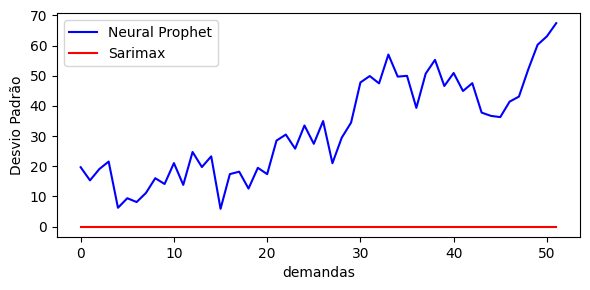

In [14]:
describe_var_desv_grafico(vars1.describe(),vars2.describe(),'demandas')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


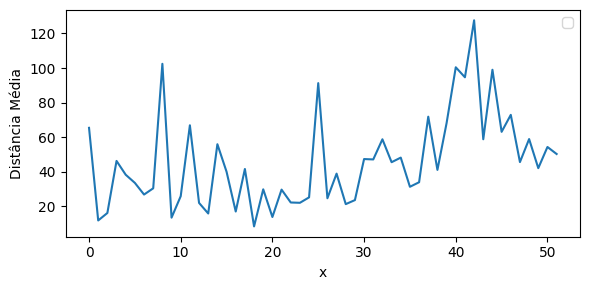

In [15]:
describe_x_1 = describe_dist_var(previsoes_sar,previsoes_np,'demandas').describe()
plot_dist(describe_x_1,'x') 

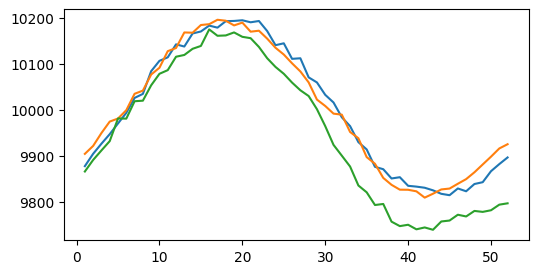

In [16]:
fig=plt.figure(figsize=(6,3))
for i in range(3):
    plt.plot(range(1,53),vars1.iloc[i,:])